In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import mlflow
import mlflow.sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR

import datetime

In [30]:
class ModelWithScaler(mlflow.pyfunc.PythonModel):
    def __init__(self, model, scaler):
        self.model = model
        self.scaler = scaler

    def predict(self, context, model_input):
        # Scale the input using the scaler
        input_scaled = self.scaler.transform(model_input)
        return self.model.predict(input_scaled)

c:\Users\ursal\Desktop\notebooks_licenta\.venv\Lib\site-packages\mlflow\pyfunc\utils\data_validation.py:168: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [31]:
df = pd.read_csv("..//dataset//processed/final_dataset.csv")
print(df)

       year  month  day  hour  DE_wind_generation_actual  DE_wind_capacity  \
0      2015      1    1     0                     8852.0           27913.0   
1      2015      1    1     1                     9054.0           27913.0   
2      2015      1    1     2                     9070.0           27913.0   
3      2015      1    1     3                     9163.0           27913.0   
4      2015      1    1     4                     9231.0           27913.0   
...     ...    ...  ...   ...                        ...               ...   
43819  2019     12   31    19                     8875.0           50452.0   
43820  2019     12   31    20                     7652.0           50452.0   
43821  2019     12   31    21                     7283.0           50452.0   
43822  2019     12   31    22                     6573.0           50452.0   
43823  2019     12   31    23                     6573.0           50452.0   

       DE_wind_speed  DE_temperature  DE_air_density  
0       

In [ ]:
df['lag_1'] = df['DE_wind_generation_actual'].shift(1)
df['lag_2'] = df['DE_wind_generation_actual'].shift(2)
df['lag_3'] = df['DE_wind_generation_actual'].shift(3)

train_df = df[df['year']<=2019].copy().dropna()
test_df = df[df['year']>2018].copy()
test_df.dropna(inplace=True)

In [34]:
print("train_df")
print(train_df)

train_df
       year  month  day  hour  DE_wind_generation_actual  DE_wind_capacity  \
3      2015      1    1     3                     9163.0           27913.0   
4      2015      1    1     4                     9231.0           27913.0   
5      2015      1    1     5                     9689.0           27913.0   
6      2015      1    1     6                    10331.0           27913.0   
7      2015      1    1     7                    10208.0           27913.0   
...     ...    ...  ...   ...                        ...               ...   
43819  2019     12   31    19                     8875.0           50452.0   
43820  2019     12   31    20                     7652.0           50452.0   
43821  2019     12   31    21                     7283.0           50452.0   
43822  2019     12   31    22                     6573.0           50452.0   
43823  2019     12   31    23                     6573.0           50452.0   

       DE_wind_speed  DE_temperature  DE_air_density  

In [35]:
print("test_df")
print(test_df)

test_df
       year  month  day  hour  DE_wind_generation_actual  DE_wind_capacity  \
35064  2019      1    1     0                    24905.0           48974.0   
35065  2019      1    1     1                    25208.0           48974.0   
35066  2019      1    1     2                    26568.0           48974.0   
35067  2019      1    1     3                    28500.0           48974.0   
35068  2019      1    1     4                    29808.0           48974.0   
...     ...    ...  ...   ...                        ...               ...   
43819  2019     12   31    19                     8875.0           50452.0   
43820  2019     12   31    20                     7652.0           50452.0   
43821  2019     12   31    21                     7283.0           50452.0   
43822  2019     12   31    22                     6573.0           50452.0   
43823  2019     12   31    23                     6573.0           50452.0   

       DE_wind_speed  DE_temperature  DE_air_density   

In [36]:
print("train_df shape:", train_df.shape)
print("test_df shape after dropna:", test_df.shape)

train_df shape: (43821, 12)
test_df shape after dropna: (8760, 12)


In [37]:
features = ['DE_wind_capacity', 'DE_wind_speed', 'DE_temperature', 'DE_air_density','lag_1','lag_2','lag_3']
target = 'DE_wind_generation_actual'

In [38]:
X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

In [41]:

# Define parameter grid
param_grid = {
    'C': [0.01,0.1, 1, 5, 10,100,200],  # Regularization strength
    'epsilon': [0.00001,0.0001,0.001,0.01, 0.1, 1],  # Tolerance for error
    'max_iter': [1000, 5000, 10000, 50000]  # Increase iterations for convergence
}

# Initialize GridSearchCV
grid_search = GridSearchCV(LinearSVR(dual='auto'), param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Train
grid_search.fit(X_train_scaled, y_train)

# Get best model
best_svr = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)

Fitting 3 folds for each of 168 candidates, totalling 504 fits
Best parameters: {'C': 200, 'epsilon': 1, 'max_iter': 10000}


In [42]:
coefficients = pd.DataFrame(best_svr.coef_, index=features, columns=['Coefficient'])
print("\nFeature Coefficients:")
print(coefficients.sort_values('Coefficient', ascending=False))


Feature Coefficients:
                   Coefficient
lag_1             16243.143644
lag_3              1449.832130
DE_wind_speed        97.698495
DE_wind_capacity     30.756217
DE_air_density      -83.276639
DE_temperature      -87.750246
lag_2             -9161.660376


In [43]:
y_pred = best_svr.predict(X_test_scaled)
test_df['predicted_wind_generation'] = y_pred

In [51]:
from sklearn.metrics import mean_absolute_error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Compute R² Score
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"mean abosulte error: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 408766.0082
Root Mean Squared Error (RMSE): 639.3481
mean abosulte error: 461.54
R² Score: 0.9959


In [45]:
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Error': y_test - y_pred,
    'Percentage': (abs(y_test - y_pred)/y_test) * 100
})
results_df.describe()

,Actual,Predicted,Error,Percentage
count,8760.000000,8760.000000,8760.000000,8760.000000
mean,14132.633219,14112.129920,20.503299,4.752629
std,9929.296694,9903.576485,639.055743,5.738385
min,400.000000,-28.265338,-4298.100403,0.000460
25%,6368.750000,6364.457858,-329.835150,1.338274
50%,11564.500000,11555.096613,-1.767349,2.999358
75%,19342.000000,19373.072771,338.003951,6.025878
max,45085.000000,45695.540047,4403.498873,103.546467


In [46]:
print(results_df[results_df['Percentage'] > 100])

       Actual  Predicted       Error  Percentage
37712   797.0 -28.265338  825.265338  103.546467


In [47]:
print(test_df)

       year  month  day  hour  DE_wind_generation_actual  DE_wind_capacity  \
35064  2019      1    1     0                    24905.0           48974.0   
35065  2019      1    1     1                    25208.0           48974.0   
35066  2019      1    1     2                    26568.0           48974.0   
35067  2019      1    1     3                    28500.0           48974.0   
35068  2019      1    1     4                    29808.0           48974.0   
...     ...    ...  ...   ...                        ...               ...   
43819  2019     12   31    19                     8875.0           50452.0   
43820  2019     12   31    20                     7652.0           50452.0   
43821  2019     12   31    21                     7283.0           50452.0   
43822  2019     12   31    22                     6573.0           50452.0   
43823  2019     12   31    23                     6573.0           50452.0   

       DE_wind_speed  DE_temperature  DE_air_density    lag_1  

In [48]:
subset = test_df[(test_df['year'] == 2019) &
                 (test_df['month'] == 1) &
                 (test_df['day'] >=1) & (test_df['day']<=8)]

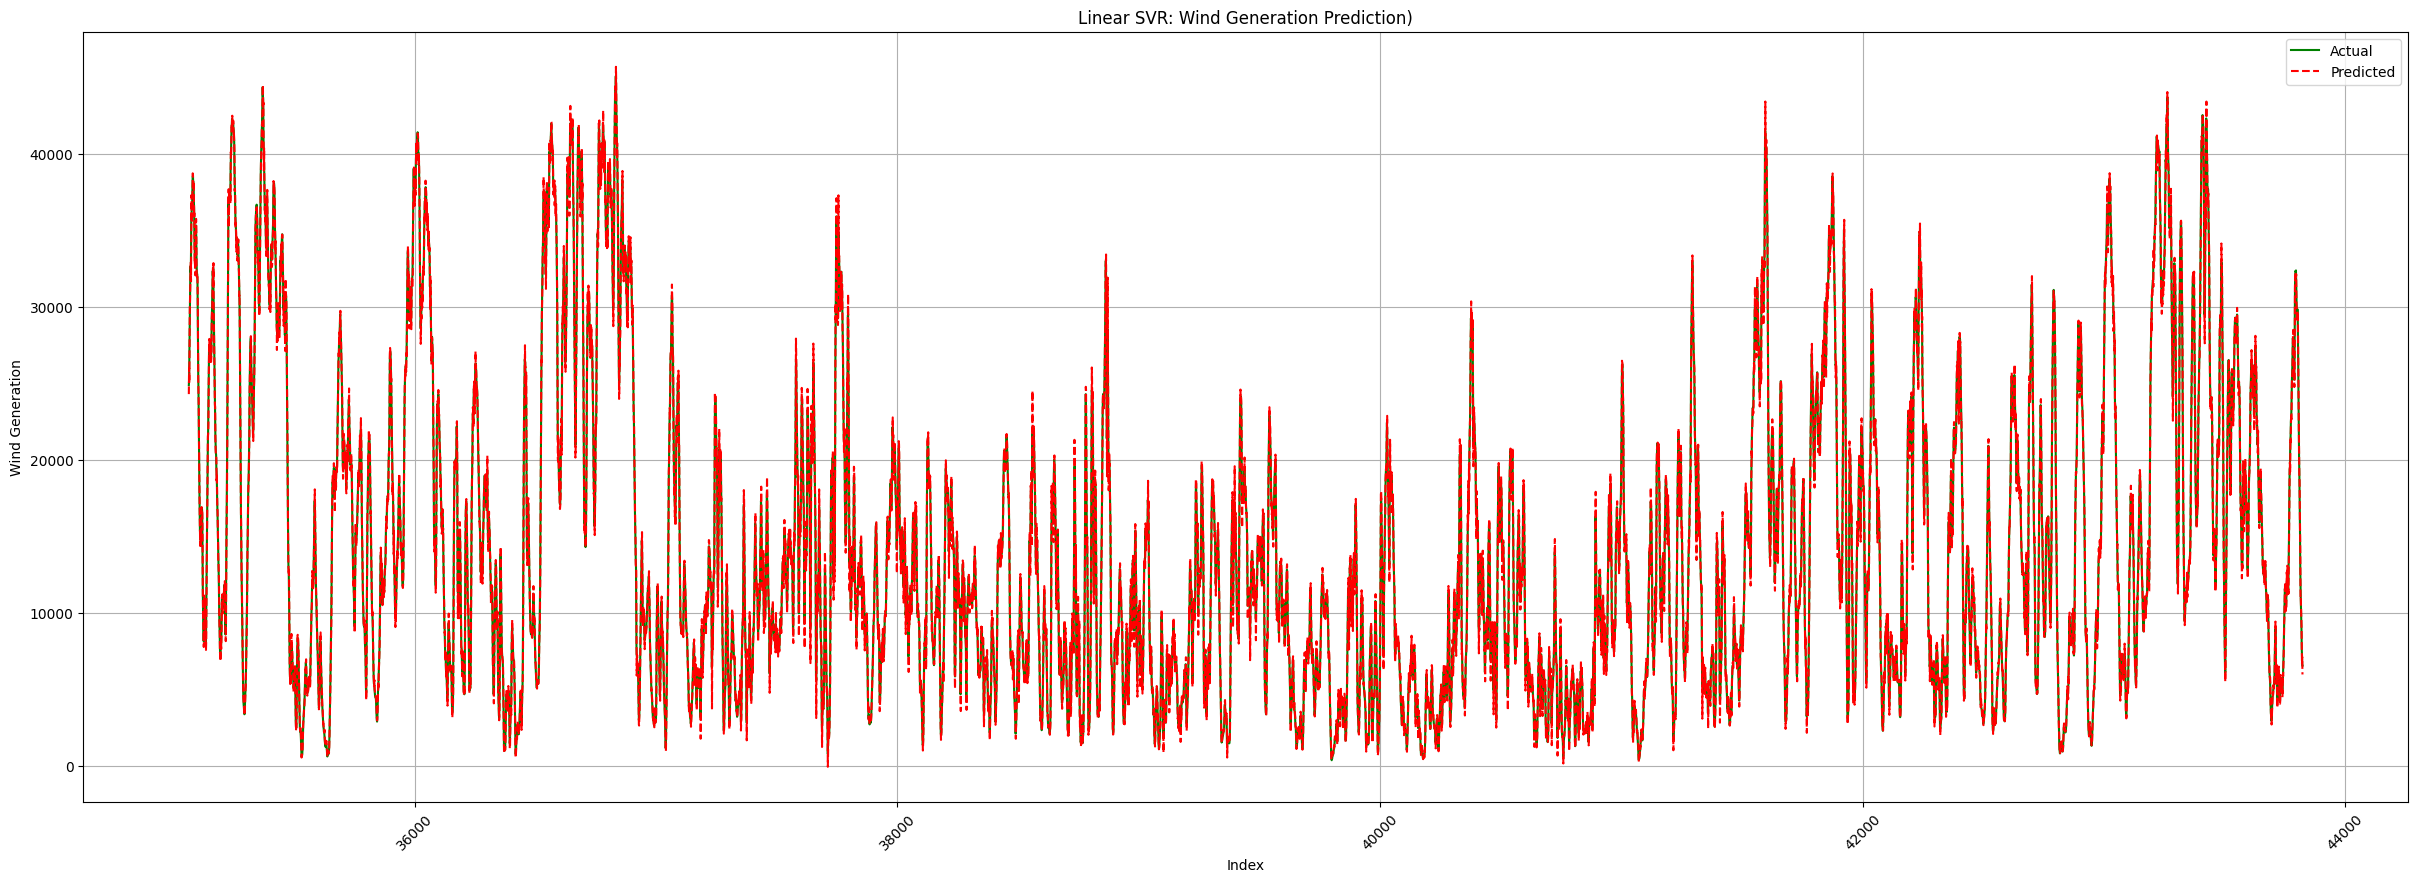

In [49]:
plt.figure(figsize=(30, 10))
plt.plot(test_df.index, test_df['DE_wind_generation_actual'], label="Actual", color="green")
plt.plot(test_df.index, test_df['predicted_wind_generation'], label="Predicted", color="red", linestyle="dashed")
plt.title('Linear SVR: Wind Generation Prediction)')
plt.xlabel('Index')
plt.ylabel('Wind Generation')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

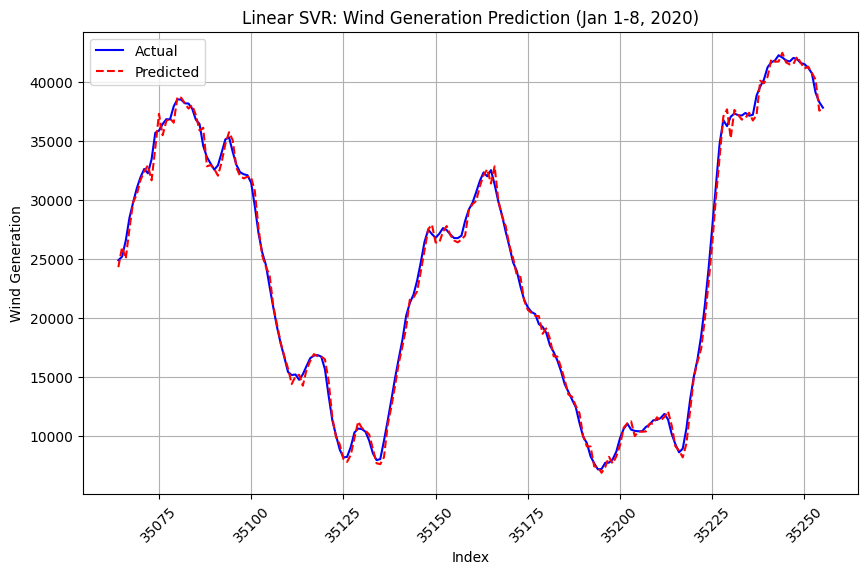

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(subset.index, subset['DE_wind_generation_actual'], label="Actual", color="blue")
plt.plot(subset.index, subset['predicted_wind_generation'], label="Predicted", color="red", linestyle="dashed")
plt.title('Linear SVR: Wind Generation Prediction (Jan 1-8, 2020)')
plt.xlabel('Index')
plt.ylabel('Wind Generation')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [23]:
date = datetime.datetime.now()
ver = date.strftime("%Y-%m-%d-%H:%M")
ver

'2025-05-05-23:28'

In [24]:
import json
import os
features_ = ['DE_wind_capacity', 'DE_wind_speed', 'DE_temperature', 'DE_air_density']
stats = train_df[features_].describe(percentiles=[.25,.5,.75]).transpose()
stats.to_json("training_feature_stats.json", indent=4)


In [25]:
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment("LinearSVR Wind Generation Prediction-3")
print("setup complete")
with mlflow.start_run(run_name=f"linearsvr_model-{ver}"):
    print("started run")

    mlflow.sklearn.pyfunc.log_model("linearSVR_withScaler",python_model=ModelWithScaler(model = best_svr, scaler= scaler))
    print("logged model")

    mlflow.log_params(best_svr.get_params())
    print("logged params")

    mlflow.log_metric("RMSE",rmse)
    print("logged RMSE")
    mlflow.log_metric("R2",r2)
    print("logged R2")
    
    mlflow.log_artifact("training_feature_stats.json")

    model_signature = mlflow.models.infer_signature(X_test,y_pred)
    model_info = mlflow.register_model(
        "runs:/{}/linearSVR_withScaler".format(mlflow.active_run().info.run_id),
        name="model_linearSVR_scaler"
    )
    print("model logged with mlflow")

os.remove("training_feature_stats.json")

KeyboardInterrupt: 

# CHESTII PE CARE LE AM TESTAT ULTERIOR:

## lag vs non lag vs norma;

In [ ]:
# --- Model with only Lags ---
lag_features = ['lag_1', 'lag_2', 'lag_3']
X_train_lags = train_df[lag_features]
X_test_lags = test_df[lag_features]

# Scale lag features separately (or use the relevant columns from the original scaling)
scaler_lags = StandardScaler()
X_train_lags_scaled = scaler_lags.fit_transform(X_train_lags)
X_test_lags_scaled = scaler_lags.transform(X_test_lags)

# Retrain or use the same grid search structure if desired
# For simplicity, let's use the best params found earlier
svr_lags = GridSearchCV(LinearSVR(dual='auto'), param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1) # Use found params
svr_lags.fit(X_train_lags_scaled, y_train)
y_pred_lags = svr_lags.predict(X_test_lags_scaled)
rmse_lags = np.sqrt(mean_squared_error(y_test, y_pred_lags))
r2_lags = r2_score(y_test, y_pred_lags)
print(f"\n--- Model with ONLY Lag Features ---")
print(f"RMSE: {rmse_lags:.4f}")
print(f"R² Score: {r2_lags:.4f}")

# --- Model with only Non-Lag Features ---
non_lag_features = ['DE_wind_capacity', 'DE_wind_speed', 'DE_temperature', 'DE_air_density']
X_train_nonlags = train_df[non_lag_features]
X_test_nonlags = test_df[non_lag_features]

scaler_nonlags = StandardScaler()
X_train_nonlags_scaled = scaler_nonlags.fit_transform(X_train_nonlags)
X_test_nonlags_scaled = scaler_nonlags.transform(X_test_nonlags)

svr_nonlags = GridSearchCV(LinearSVR(dual='auto'), param_grid, cv=tscv, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1) # Use found params
svr_nonlags.fit(X_train_nonlags_scaled, y_train)
y_pred_nonlags = svr_nonlags.predict(X_test_nonlags_scaled)
rmse_nonlags = np.sqrt(mean_squared_error(y_test, y_pred_nonlags))
r2_nonlags = r2_score(y_test, y_pred_nonlags)
print(f"\n--- Model with ONLY Non-Lag Features ---")
print(f"RMSE: {rmse_nonlags:.4f}")
print(f"R² Score: {r2_nonlags:.4f}")

print(f"\n--- Original Model (All Features) ---")
print(f"RMSE: {rmse:.4f}") # Original RMSE calculated earlier
print(f"R² Score: {r2:.4f}") # Original R2 calculated earlier

Fitting 3 folds for each of 168 candidates, totalling 504 fits

--- Model with ONLY Lag Features ---
RMSE: 684.4421
R² Score: 0.9956
Fitting 3 folds for each of 168 candidates, totalling 504 fits

--- Model with ONLY Non-Lag Features ---
RMSE: 5186.5441
R² Score: 0.7500

--- Original Model (All Features) ---
RMSE: 677.5350
R² Score: 0.9957


## corr matrix si coeff features

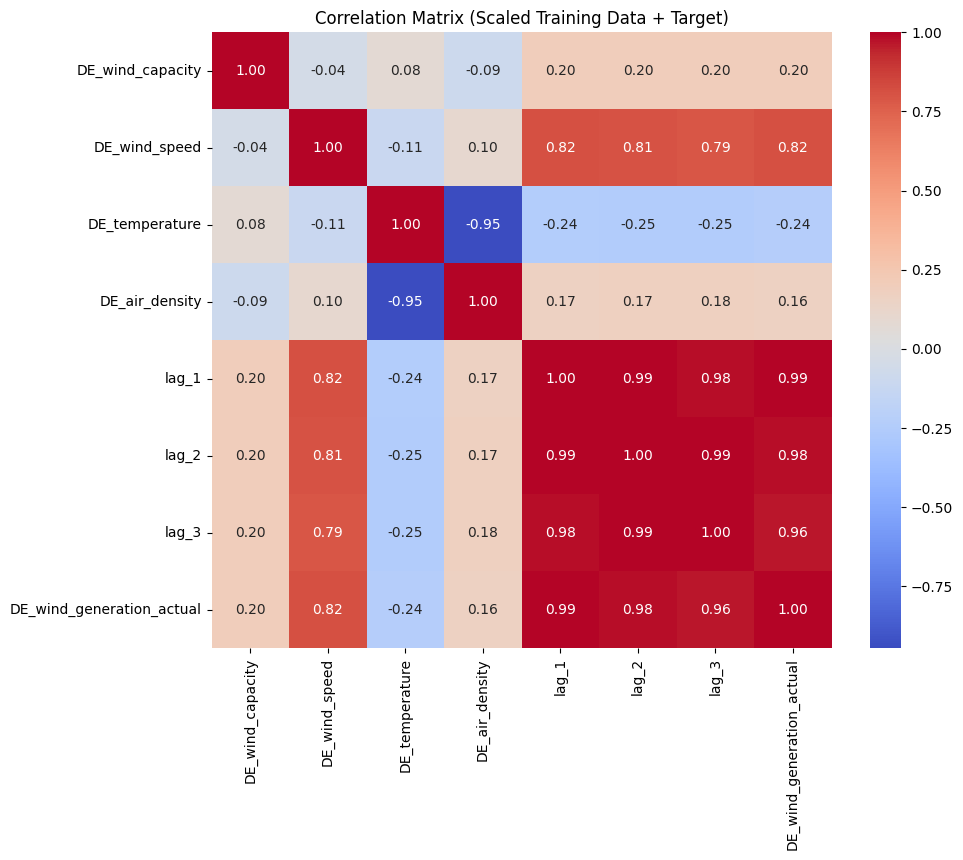


Correlations with Target:
DE_wind_generation_actual    1.000000
lag_1                        0.994677
lag_2                        0.981208
lag_3                        0.962598
DE_wind_speed                0.817570
DE_wind_capacity             0.199651
DE_air_density               0.164643
DE_temperature              -0.238747
Name: DE_wind_generation_actual, dtype: float64


In [ ]:
# Add target back to X_train_scaled for correlation calculation
train_data_for_corr = pd.DataFrame(X_train_scaled, columns=features)
train_data_for_corr[target] = y_train.values # Use .values to avoid index alignment issues if indices differ

plt.figure(figsize=(10, 8))
sns.heatmap(train_data_for_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Scaled Training Data + Target)')
plt.show()

print("\nCorrelations with Target:")
print(train_data_for_corr.corr()[target].sort_values(ascending=False))

## Residuals plot

In [ ]:
test_df['residual'] = test_df['DE_wind_generation_actual'] - test_df['predicted_wind_generation']

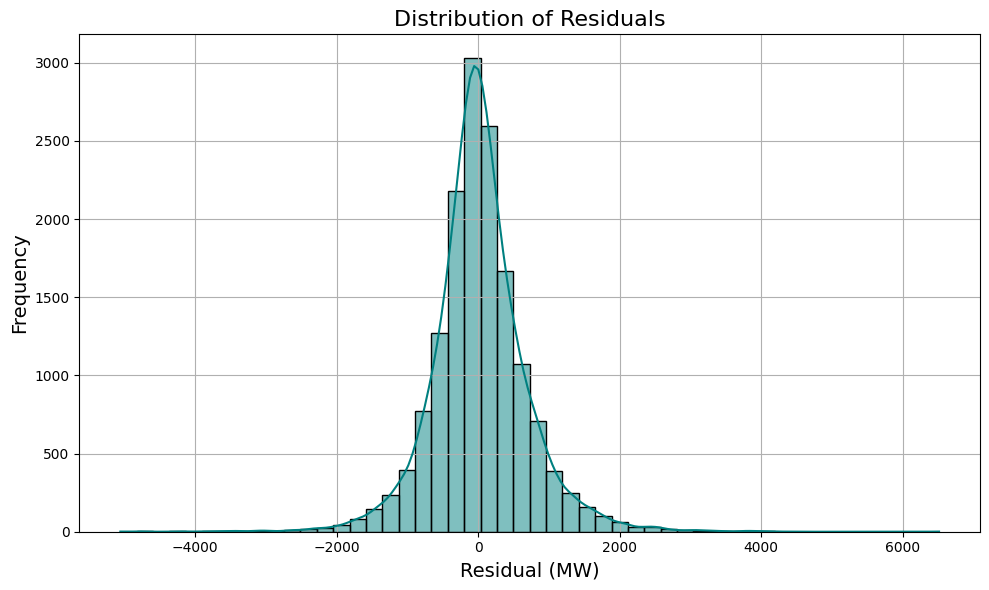

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(test_df['residual'], bins=50, kde=True, color='teal')
plt.title('Distribution of Residuals', fontsize=16)
plt.xlabel('Residual (MW)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


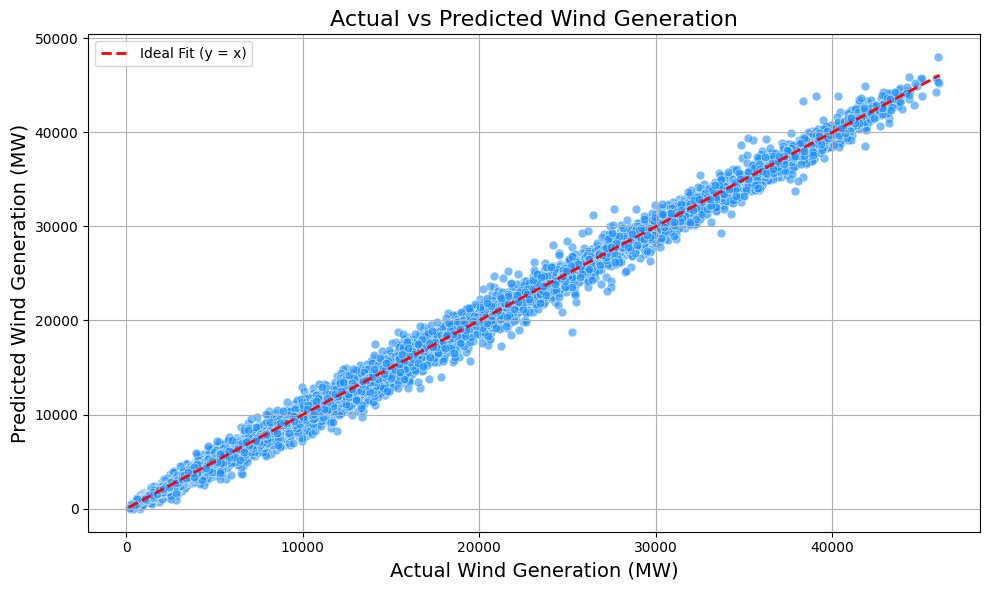

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_df['DE_wind_generation_actual'], y=test_df['predicted_wind_generation'], color='dodgerblue', s=40, alpha=0.6)
plt.plot([test_df['DE_wind_generation_actual'].min(), test_df['DE_wind_generation_actual'].max()],
         [test_df['DE_wind_generation_actual'].min(), test_df['DE_wind_generation_actual'].max()],
         color='red', linestyle='--', linewidth=2, label='Ideal Fit (y = x)')
plt.title('Actual vs Predicted Wind Generation', fontsize=16)
plt.xlabel('Actual Wind Generation (MW)', fontsize=14)
plt.ylabel('Predicted Wind Generation (MW)', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


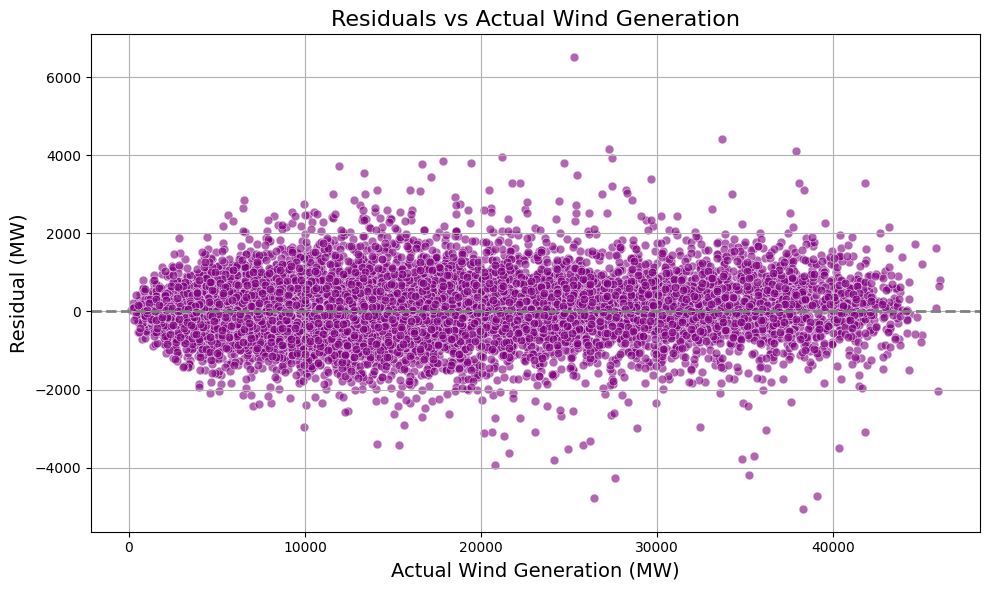

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_df['DE_wind_generation_actual'], y=test_df['residual'], color='purple', s=40, alpha=0.6)
plt.axhline(0, color='gray', linestyle='--', linewidth=2)
plt.title('Residuals vs Actual Wind Generation', fontsize=16)
plt.xlabel('Actual Wind Generation (MW)', fontsize=14)
plt.ylabel('Residual (MW)', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


## feature importance

C:\Users\ursal\AppData\Local\Temp\ipykernel_18976\3761066473.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=coef_importance.values, y=coef_importance.index, palette='viridis')


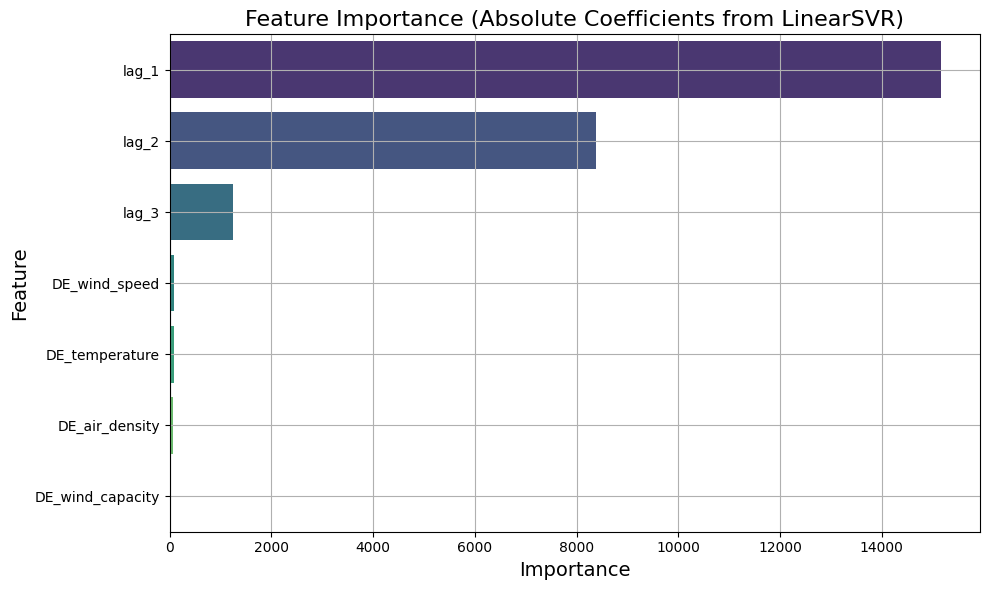

In [ ]:
coef_importance = pd.Series(np.abs(best_svr.coef_), index=features)
coef_importance = coef_importance.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=coef_importance.values, y=coef_importance.index, palette='viridis')
plt.title('Feature Importance (Absolute Coefficients from LinearSVR)', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\ursal\AppData\Local\Temp\ipykernel_18976\1289160441.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='magma')


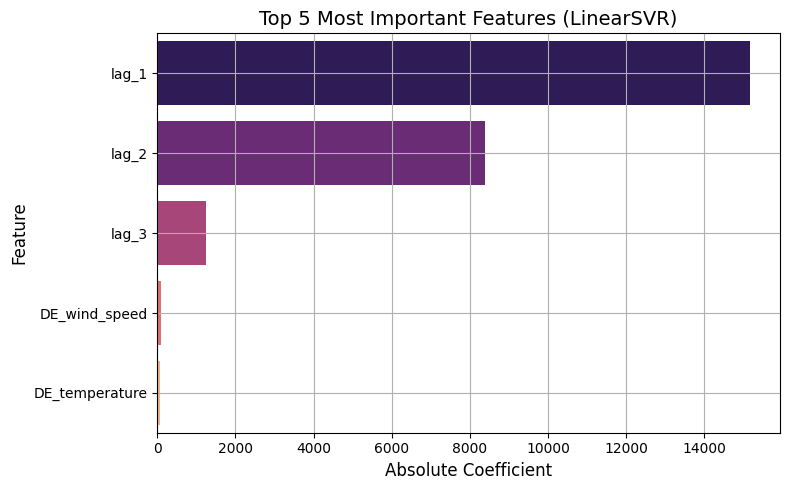

In [ ]:
# Show only top 5 important features
top_n = 5
top_features = coef_importance.head(top_n)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_features.values, y=top_features.index, palette='magma')
plt.title(f'Top {top_n} Most Important Features (LinearSVR)', fontsize=14)
plt.xlabel('Absolute Coefficient', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
